# Kaggle Carvana Image Masking Challenge

1.Data analysis 

2.Training preparation

3.Neural Network

4.Start Training

5.Get result csv and submit


## 1.Data analysis 
### 1.1import what you need

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pylab as plt


### 1.2 Data Size and Data Number

In [4]:
print("Input file list :",os.listdir("../input"))
print("test :",len(os.listdir("../input/test")))
print("train :",len(os.listdir("../input/train")))
print("train_masks :",len(os.listdir("../input/train_masks")))
train_masks_csv = pd.read_csv("../input/train_masks.csv")
print("train_masks.csv shape:",train_masks_csv.shape)
sample_submission_csv = pd.read_csv("../input/sample_submission.csv")
print("sample_submission.csv shape:",sample_submission_csv.shape)
metadata_csv = pd.read_csv("../input/metadata.csv")
print("metadata.csv(didn't use in this time) shape:",metadata_csv.shape)


Input file list : ['metadata.csv', 'sample_submission.csv', 'test', 'train', 'train_masks', 'train_masks.csv']
test : 2597
train : 5088
train_masks : 5088
train_masks.csv shape: (5088, 2)
sample_submission.csv shape: (100064, 2)
metadata.csv(didn't use in this time) shape: (6572, 6)


### 1.3 train_masks.csv analysis
In train_masks.csv it include the mask as the submission require run-length encoding on the pixel values. 

let's read it out and decode it, show it.

Reference ： https://www.kaggle.com/paulorzp/run-length-encode-and-decode

(1280, 1918)


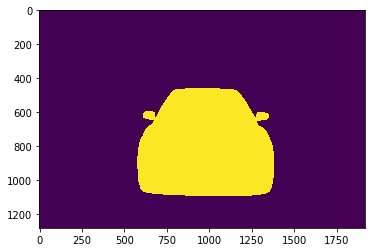

In [5]:
def length_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def length_encode(mask):
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

train_masks_csv = pd.read_csv("../input/train_masks.csv")
mask = length_decode(train_masks_csv["rle_mask"][0],(1280,1918))
print(mask.shape)

%matplotlib inline
plt.imshow(mask)
plt.show()

### 1.4 Train image analysis
From the previous conclusions, we know, train image include 5088 images

It include 318 car's photographs in 16 directions

Car id number : 318


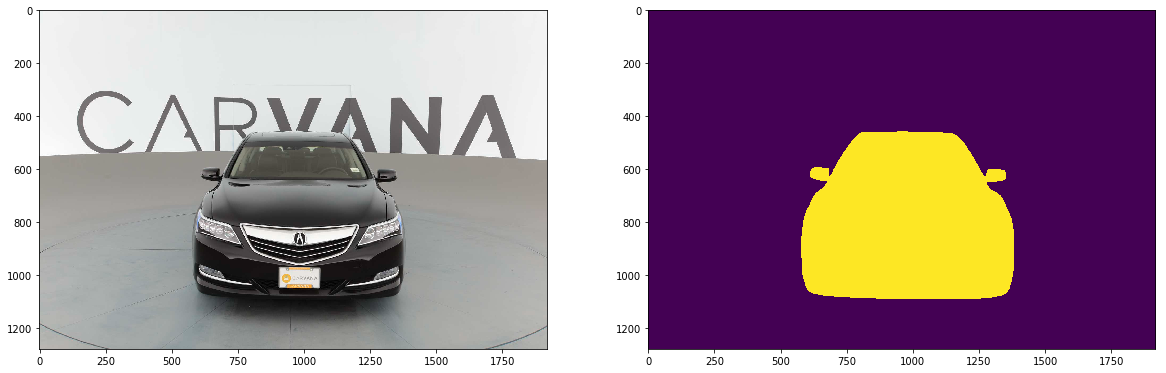

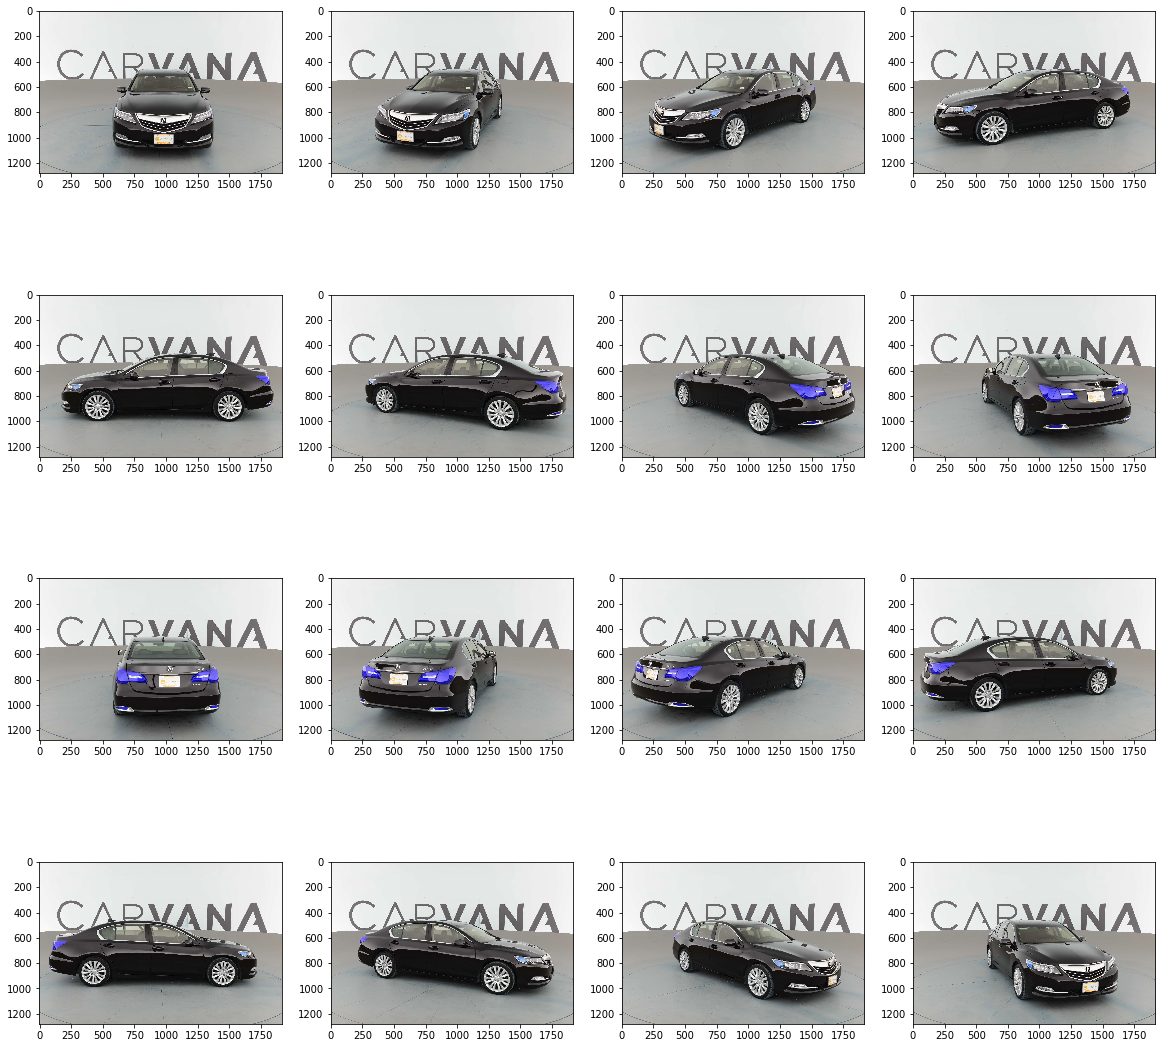

In [76]:
def get_image(image_id, image_type):
    if "image" == image_type:
        fname = "../input/train/{}".format(image_id)
        img = cv2.imread(fname)
        return img
    if "mask" == image_type:
        mask = length_decode(train_masks_csv["rle_mask"][train_masks_csv["img"].isin([image_id])][0],(1280,1918))
        return mask

    
train_masks_csv['id'] = train_masks_csv['img'].apply(lambda x: x[:-7])
print("Car id number :",len(train_masks_csv['id'].unique()))
image = get_image(train_masks_csv['id'][0]+"_01.jpg","image")
mask = get_image(train_masks_csv['id'][0]+"_01.jpg","mask")

%matplotlib inline
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(mask)
plt.show()

fig,axes = plt.subplots(4,4,figsize=(20, 20))
for i in range(16):
    line = int(i/4)
    col = int(i%4)
    ax1=axes[line, col]
    image = get_image(train_masks_csv['id'][0]+"_{:0>2d}.jpg".format(i+1),"image")
    ax1.imshow(image)
plt.show()

## 2.Training preparation
Before start training, we need to Prepare training list and test list
and then build a batch generator.

Then when we training, our model will fit on the generator.

### 2.1Prepare training list and test list

The training data consisted of 5,088 photos of 318 car's.

I decided to randomly select 18 cars, all 16 directions as test data.
In addition, two random angles of rest 300 vehicles are selected as test data.
Then we get 888 test data, 4200 training data


In [99]:
def train_test_split(ids_train):
    car_id = ids_train['img'].apply(lambda x: x[:-7])
    car_id = car_id.unique().tolist()
    test_list = []
    train_list = []
    #--- add 18 car in test_list
    for i in range(18):
        pick_car = random.choice(car_id)
        car_id.remove(pick_car)
        for j in range(16):
            test_list.append(pick_car+'_{:0>2d}.jpg'.format(j+1))

    #--- random add every car 2 direction to test_list
    for each_id in car_id:
        random_id = random.sample(range(16),2)
        for num in range(16):
            if num in random_id:
                test_list.append(each_id+'_{:0>2d}.jpg'.format(num))
            else:
                train_list.append(each_id+'_{:0>2d}.jpg'.format(num))
    
    return train_list, test_list

train_list, test_list = train_test_split(train_masks_csv)
    
print("Test list length:",len(test_list))
print("Train list length:",len(train_list))

Test list length: 888
Train list length: 4200


### 2.2 batch generator

In [ ]:
def batch_generator(fnamelist, batch_size):
    while True:
        shuffle_indices = range(len(fnamelist))
        shuffle_indices = random.shuffle(shuffle_indices)
        
        for i in range(0, len(shuffle_indices),batch_size):
            x_batch = []
            y_batch = []
            
            for idx in shuffle_indices[i:i+batch_size]:
                image = get_image(fnamelist[idx],"image")
                mask = get_image(fnamelist[idx],"mask")
                mask = np.expand_dims(mask, axis=-1)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            yield x_batch, y_batch

## 3.Neural Network
Build a Deep Neural Network ,modify from U-Net（U_Net plays a dominant role in image segmentation）

The main structure of the network is the same as that of the paper. ([U-net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28))

At the bottom of the U-Net, I use 3 different level dilated convolutions and add them together, to integrating the features of larger regions


### 3.1 Common Loss（Image Segmentation）
dice and bce is ofen using in Image Segmentation

In [81]:
import keras.backend as K #Using backend will make it faster to calculate
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### 3.2 Build the Neural Network

This unet is based on our lab's code,
I change some node size to make it train Faster
It only include Total params: 2,730,721 (in CT segmentation it often ten times)
Because of the simplicity of the task, the scores on the list reached 0.997+
So if I keep cut the size of the neural network 
The end result will be very low on the list, even if only a few points are lost.

In order to get high score in competition, I will use a larger network within the allowable range.
In practical engineering, I will find the balance point and use the least resources to get the best results.



In [79]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, add, concatenate, Dropout

def CreateConvBlock(x, filters , n = 2, name = 'convblock'):
    for i in range(n):
        x = Conv2D(filters[i], (3,3), activation='relu', padding='same',name=name+'_conv'+str(i+1))(x)
    convresult = x
    x = MaxPooling2D(pool_size=(2,2),strides=(2, 2) ,name=name+'_pooling')(x)
    return x, convresult

#Origin, three times dilation conv at the bottom，and add them in the end.
def BottleBlock(x, filters,depth=3,
               activation='relu',name = 'Bottle'):
    dilated_layers = []
    for i in range(depth):
        x = Conv2D(filters, (3,3),
                   activation='relu', padding='same', dilation_rate=2**i)(x)
        dilated_layers.append(x)
    return add(dilated_layers, name = name+'_add')

def CreateUpConvBlock(x, contractpart, filters, n = 2, name = 'upconvblock'):
    x = UpSampling2D(size=(2, 2),name = name+'upsample')(x)
    x = Conv2D(filters[0], (3,3), activation='relu', padding='same',name = name+'conv_0')(x)
    x = concatenate([contractpart, x],name = name+'_concat')
    for i in range(n):
        x = Conv2D(filters[i], (3,3), activation='relu', padding='same',name = name+'conv_'+str(i+1))(x)
    return x

def ConstructUnetModel(input, nclass = 1, use_dropout = True):
    x, contract1 = CreateConvBlock(input, (32, 32), n = 2, name = 'contract1')
    x, contract2 = CreateConvBlock(x, (64, 64), n = 2, name = 'contract2')
    x, contract3 = CreateConvBlock(x, (128, 128), n = 2, name = 'contract3')
    x = BottleBlock(x, 256, depth = 3, name = 'Bottle')
    if use_dropout:
        x = Dropout(0.3, name='dropout')(x)
    x = CreateUpConvBlock(x, contract3, (128, 128), n = 2,name = 'expand3')
    x = CreateUpConvBlock(x, contract2, (64, 64), n = 2,name = 'expand2')
    x = CreateUpConvBlock(x, contract1, (32, 32), n = 2,name = 'expand1')
    #last classify
    x = Conv2D(nclass, (1, 1), activation='sigmoid',name='classify')(x)
    
    return x

In [82]:
from keras.models import Model
from keras.optimizers import RMSprop

def get_net(input_shape=(1920, 1280, 3), lr = 0.0001):
    inputs = Input(shape=input_shape, name="input")
    classify = ConstructUnetModel(inputs)
    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=RMSprop(lr), loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

model = get_net()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1920, 1280, 3 0                                            
__________________________________________________________________________________________________
contract1_conv1 (Conv2D)        (None, 1920, 1280, 3 896         input[0][0]                      
__________________________________________________________________________________________________
contract1_conv2 (Conv2D)        (None, 1920, 1280, 3 9248        contract1_conv1[0][0]            
__________________________________________________________________________________________________
contract1_pooling (MaxPooling2D (None, 960, 640, 32) 0           contract1_conv2[0][0]            
__________________________________________________________________________________________________
contract2_

### 3.3 dilated convolutions in bottom

![](dilated_convolutions.jpg)
picture from https://www.sohu.com/a/160696860_610300

## 4.Start Training

even using 11G GTX1080ti the memory still not enough to train model in 1920 x 1280 resolution
So in the model, I down sample the image as 1024 x 1024
Then the training batch size can be 3

I didn't using any data enhancement because the data number is enough and the direction is always same 16 direction.
But in other higher scores, I found that almost everyone used data enhancement such as rotation and translation. 
If time permits, I will use some data enhancement methods to achieve higher scores.

Because the car that needs to be cut is a whole, the reduction of resolution( Down-sampling and up-sampling ) has little effect on the final result.

This part I run script on our lab's GTX1080Ti Computer
So it didn't include in the Notebooks.
I will paste the logs during training at here:

In [ ]:
Epoch 1/100
 - 910s - loss: 0.2189 - dice_coef: 0.9042 - val_loss: 0.0891 - val_dice_coef: 0.9662
Epoch 2/100
 - 898s - loss: 0.0651 - dice_coef: 0.9759 - val_loss: 0.0453 - val_dice_coef: 0.9826
Epoch 3/100
 - 898s - loss: 0.0419 - dice_coef: 0.9844 - val_loss: 0.0351 - val_dice_coef: 0.9871
Epoch 4/100
 - 897s - loss: 0.0293 - dice_coef: 0.9888 - val_loss: 0.0306 - val_dice_coef: 0.9884
Epoch 5/100
 - 897s - loss: 0.0280 - dice_coef: 0.9902 - val_loss: 0.0274 - val_dice_coef: 0.9895
Epoch 6/100
 - 896s - loss: 0.0231 - dice_coef: 0.9917 - val_loss: 0.0161 - val_dice_coef: 0.9936
Epoch 7/100
 - 896s - loss: 0.0224 - dice_coef: 0.9922 - val_loss: 0.4325 - val_dice_coef: 0.8802
Epoch 8/100
 - 895s - loss: 0.0163 - dice_coef: 0.9936 - val_loss: 0.0131 - val_dice_coef: 0.9946
Epoch 9/100
 - 895s - loss: 0.0172 - dice_coef: 0.9937 - val_loss: 0.0114 - val_dice_coef: 0.9953
Epoch 10/100
 - 895s - loss: 0.0138 - dice_coef: 0.9945 - val_loss: 0.0131 - val_dice_coef: 0.9947
Epoch 11/100
 - 897s - loss: 0.0165 - dice_coef: 0.9943 - val_loss: 0.0107 - val_dice_coef: 0.9955
Epoch 12/100
 - 895s - loss: 0.0139 - dice_coef: 0.9946 - val_loss: 0.0118 - val_dice_coef: 0.9951
Epoch 13/100
 - 895s - loss: 0.0134 - dice_coef: 0.9949 - val_loss: 0.0110 - val_dice_coef: 0.9955
Epoch 14/100
 - 895s - loss: 0.0149 - dice_coef: 0.9949 - val_loss: 0.0110 - val_dice_coef: 0.9955
Epoch 15/100
 - 894s - loss: 0.0120 - dice_coef: 0.9953 - val_loss: 0.0099 - val_dice_coef: 0.9958
Epoch 16/100
 - 894s - loss: 0.0125 - dice_coef: 0.9952 - val_loss: 0.0100 - val_dice_coef: 0.9957
Epoch 17/100
 - 894s - loss: 0.0139 - dice_coef: 0.9952 - val_loss: 0.0095 - val_dice_coef: 0.9960
Epoch 18/100
 - 894s - loss: 0.0143 - dice_coef: 0.9952 - val_loss: 0.0110 - val_dice_coef: 0.9955
Epoch 19/100
 - 893s - loss: 0.0122 - dice_coef: 0.9955 - val_loss: 0.0300 - val_dice_coef: 0.9903
Epoch 20/100
 - 894s - loss: 0.0114 - dice_coef: 0.9957 - val_loss: 0.0095 - val_dice_coef: 0.9960
Epoch 21/100
 - 893s - loss: 0.0109 - dice_coef: 0.9957 - val_loss: 0.0091 - val_dice_coef: 0.9961
Epoch 22/100
 - 893s - loss: 0.0114 - dice_coef: 0.9957 - val_loss: 0.0097 - val_dice_coef: 0.9960
Epoch 23/100
 - 893s - loss: 0.0100 - dice_coef: 0.9960 - val_loss: 0.0090 - val_dice_coef: 0.9962
Epoch 24/100
 - 893s - loss: 0.0102 - dice_coef: 0.9959 - val_loss: 0.0123 - val_dice_coef: 0.9954
Epoch 25/100
 - 892s - loss: 0.0120 - dice_coef: 0.9957 - val_loss: 0.0089 - val_dice_coef: 0.9962
Epoch 26/100
 - 893s - loss: 0.0108 - dice_coef: 0.9960 - val_loss: 0.0085 - val_dice_coef: 0.9964
Epoch 27/100
 - 893s - loss: 0.0137 - dice_coef: 0.9959 - val_loss: 0.0096 - val_dice_coef: 0.9962
Epoch 28/100
 - 893s - loss: 0.0097 - dice_coef: 0.9961 - val_loss: 0.0088 - val_dice_coef: 0.9963
Epoch 29/100
 - 892s - loss: 0.0100 - dice_coef: 0.9960 - val_loss: 0.0252 - val_dice_coef: 0.9933
Epoch 30/100
 - 892s - loss: 0.0089 - dice_coef: 0.9963 - val_loss: 0.0090 - val_dice_coef: 0.9962
Epoch 31/100
 - 893s - loss: 0.0102 - dice_coef: 0.9960 - val_loss: 0.0092 - val_dice_coef: 0.9962

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 32/100
 - 893s - loss: 0.0075 - dice_coef: 0.9968 - val_loss: 0.0078 - val_dice_coef: 0.9966
Epoch 33/100
 - 892s - loss: 0.0073 - dice_coef: 0.9968 - val_loss: 0.0077 - val_dice_coef: 0.9967
Epoch 34/100
 - 893s - loss: 0.0073 - dice_coef: 0.9969 - val_loss: 0.0077 - val_dice_coef: 0.9967
Epoch 35/100
 - 892s - loss: 0.0072 - dice_coef: 0.9969 - val_loss: 0.0076 - val_dice_coef: 0.9967
Epoch 36/100
 - 893s - loss: 0.0072 - dice_coef: 0.9969 - val_loss: 0.0076 - val_dice_coef: 0.9967
Epoch 37/100
 - 893s - loss: 0.0071 - dice_coef: 0.9969 - val_loss: 0.0077 - val_dice_coef: 0.9967

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 38/100
 - 892s - loss: 0.0070 - dice_coef: 0.9970 - val_loss: 0.0076 - val_dice_coef: 0.9967
Epoch 39/100
 - 893s - loss: 0.0070 - dice_coef: 0.9970 - val_loss: 0.0076 - val_dice_coef: 0.9967
Epoch 40/100
 - 893s - loss: 0.0069 - dice_coef: 0.9970 - val_loss: 0.0075 - val_dice_coef: 0.9967
Epoch 41/100
 - 892s - loss: 0.0069 - dice_coef: 0.9970 - val_loss: 0.0076 - val_dice_coef: 0.9967
Epoch 42/100
 - 892s - loss: 0.0069 - dice_coef: 0.9970 - val_loss: 0.0076 - val_dice_coef: 0.9967

Epoch 00042: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 00042: early stopping

## 5.Get result csv and submit
The final output image coding must be performed at the resolution of 1918x1280. After two attempts, it is found that the slight difference in resolution will lead to a completely different final result.
![](result.png)

Use official mask as example

mask1 shape: (1280, 1918)
mask2 shape: (1280, 1920)


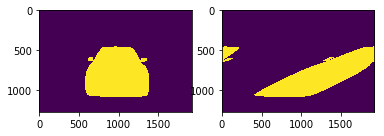

In [7]:
train_masks_csv = pd.read_csv("../input/train_masks.csv")

mask1 = length_decode(train_masks_csv["rle_mask"][0],(1280,1918))
mask2 = length_decode(train_masks_csv["rle_mask"][0],(1280,1920))
print('mask1 shape:',mask1.shape)
print('mask2 shape:',mask2.shape)
%matplotlib inline
plt.subplot(121)
plt.imshow(mask1)
plt.subplot(122)
plt.imshow(mask2)
plt.show()


In [ ]:
#predict_csv.py
import cv2
import numpy as np
import pandas as pd
import threading
import queue
import tensorflow as tf
from tqdm import tqdm
from keras.models import load_model
from model import  bce_dice_loss, dice_coef

# model size
MODEL_WIDTH = 1024
MODEL_HEIGHT = 1024
BATCH_SIZE = 10

#submit size(must be 1918 x 1280)

ORIG_WIDTH = 1918
ORIG_HEIGHT = 1280

def length_encode(mask):
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

test_csv = pd.read_csv('../input/sample_submission.csv')
test_list = list(test_csv['img'])
result_list = []

model = load_model(
    filepath='logs/model_weights.hdf5',
    custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}
)

#graph = tf.get_default_graph()

for start in tqdm(range(0, len(test_list), BATCH_SIZE)):
    end = min(start + BATCH_SIZE, len(test_list)) #edge security
    test_fname_batch = test_list[start:end]
    test_img_batch = []
    for fname in test_fname_batch:
        test_img = cv2.imread('../input/test/{}'.format(fname))
        test_img = cv2.resize(test_img, (MODEL_WIDTH, MODEL_HEIGHT))

        test_img_batch.append(test_img)

    input_batch = np.array(test_img_batch)

    result_batch = model.predict_on_batch(input_batch)
    result_batch = np.squeeze(result_batch, axis=3)

    for result in result_batch:
        result_orgsize = cv2.resize(result, (ORIG_WIDTH, ORIG_HEIGHT))
        mask = result_orgsize > 0.5
        result_coded = length_encode(mask)
        result_list.append(result_coded)
    
    print(start,'/',len(test_list))


df = pd.DataFrame({'img': test_list, 'rle_mask': result_list})
df.to_csv('submission.csv.gz', index=False, compression='gzip')